In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import time

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter
import socket
from datetime import datetime
import os

from functools import partial

from agents import Agent
from replay_buffers import *
from utils import *

import copy

c:\Users\Sam\miniconda3\envs\rl-project-bortolato\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define the parameters for the simulations (same used for training the agent)

In [2]:
from environment import SimulationEnvironment0
num_blackholes=1
sim = SimulationEnvironment0(num_simulations=128,
                            num_blackholes=num_blackholes, 
                            force_constant=0.002, 
                            velocity_scale=0.01,
                            goal_threshold=0.05,
                            device='cuda')
states = sim.get_state()

Define the iperparameters of the network (if you want to load the weights the network must match)

In [3]:
hidden_size = 512
simlog_res = 255
simlog_half_res = simlog_res//2
simlog_max_range = 1
actions_res = 5
levels=2

discrete_actions = False
use_two_hot = False


input_type = 'complete'
smoothing = 1e-2

Create the networks

In [4]:
bin_values = (torch.arange(simlog_res)-simlog_half_res).cuda()/simlog_half_res*simlog_max_range
bin_values = bin_values.sign()*(bin_values.abs().exp()-1)

dec_x, dec_y = torch.meshgrid(torch.arange(actions_res)/(actions_res-1)*2-1, torch.arange(actions_res)/(actions_res-1)*2-1)
dec_x, dec_y = dec_x.flatten().cuda(), dec_y.flatten().cuda()

# initialize the networks
if discrete_actions:
    action_dim = actions_res**2             # output shape of the actor
    compute_dist = compute_dist_discrete
    decode_action = partial(decode_action_discrete, dec_x=dec_x, dec_y=dec_y)
    action_shape = ()                     # shape after sampling the dist, before decoding
else:
    action_dim = 5
    compute_dist = compute_dist_continuous
    decode_action = decode_action_continuous
    action_shape = (2,)

if use_two_hot:
    value_dimension = simlog_res
    decode_values = partial(decode_value_symlog, bin_values)
    critic_error_func = partial(critic_error_func_symlog, simlog_max_range, simlog_res, simlog_half_res, smoothing)
else:
    value_dimension = 1
    decode_values = lambda x : x[:,0]
    critic_error_func = critic_error_func_normal


actor = Agent((num_blackholes+2)*2, hidden_size, levels, input_type, critic=False, action_dimension=action_dim).cuda()
V = Agent((num_blackholes+2)*2, hidden_size, levels, input_type, actor=False, value_dimension=value_dimension).cuda()
Q = Agent(hidden_size + 2, hidden_size, levels, input_type='base', actor=False, value_dimension=value_dimension).cuda()


c:\Users\Sam\miniconda3\envs\rl-project-bortolato\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Load the weights of the untrained network

In [5]:
log_dir = 'runs/ppo_acer_sac/ppo2_rr1/0/Sep04_18-23-18_Laptop-SAM'
agent_dict = torch.load(os.path.join(log_dir,'original_model.pth'))
actor.load_state_dict(agent_dict['actor'])
V.load_state_dict(agent_dict['V'])
Q.load_state_dict(agent_dict['Q'])

<All keys matched successfully>

Run the simulation

It's possible to change the starting position of the ship, the position of the goal and the position of the black-hole

Redrawing an image on a notebook is always a mess, visualizing a gif is smoother but reqires moviepy
```
!pip install moviepy
```
alternatively just slow down the frames adding the time.sleep()

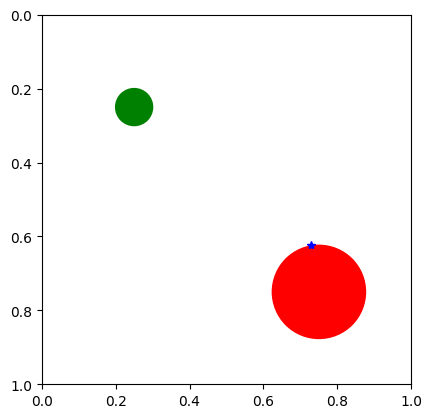

In [6]:
frames = []

sim = SimulationEnvironment0(num_simulations=1,
                                num_blackholes=num_blackholes, 
                                force_constant=0.002, 
                                velocity_scale=0.01,
                                goal_threshold=0.05,
                                max_steps=250,
                                device='cuda')

sim.states[0,0] = torch.tensor([0.5,0.2])       # starting position
sim.states[0,1] = torch.tensor([0.25,0.25])     # goal position
sim.states[0,2] = torch.tensor([0.75,0.75])     # black-hole position

states = sim.get_state()


for i in range(200):

    # plot

    #time.sleep(0.25)

    fig, ax = plt.subplots()
    plt.plot(states[0,0,0].cpu(),states[0,0,1].cpu(),'*b')
    goal = plt.Circle((states[0,1,0].cpu(),states[0,1,1].cpu()),sim.goal_threshold, color='g')
    ax.add_patch(goal)
    black_hole =plt.Circle((states[0,2,0].cpu(),states[0,2,1].cpu()),sim.crash_threshold, color='r')
    ax.add_patch(black_hole)
    ax.set_aspect('equal')
    plt.xlim([0,1])
    plt.ylim([1,0])
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(img)
    clear_output()
    plt.show()

    # flatten the state
    states = states.reshape(states.shape[0],-1).cuda()

    # compute action distribution according to the current policy
    actions, _, _ = actor(states)
    dist = compute_dist(actions)

    # sample an action
    sampled_action = dist.sample()
    sampled_action_decoded, log_prob = decode_action(dist, sampled_action)

    # simulation step
    rewards, states, terminals = sim.step(sampled_action_decoded)

    if torch.any(terminals):
        break

In [7]:
# !pip install moviepy  #required to make the gif

In [8]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(frames, fps=20)
clip.write_gif('resources/original.gif', fps=20)

MoviePy - Building file resources/original.gif with imageio.


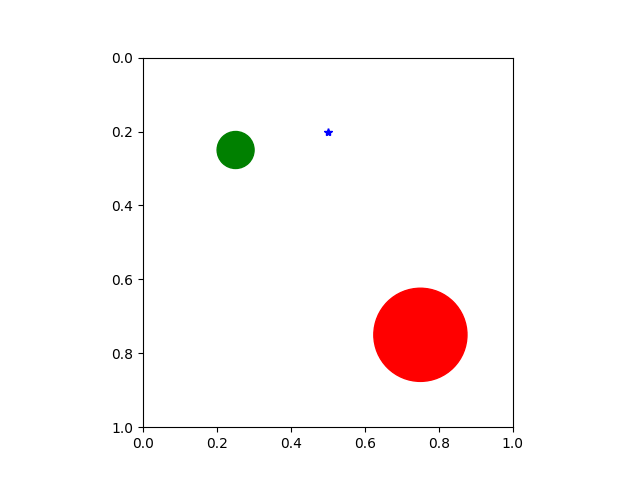

In [9]:
from IPython.display import display, Image
Image('resources/original.gif')

Load the weights of the trained network

In [10]:
log_dir = 'runs/ppo_acer_sac/ppo2_rr1/0/Sep04_18-23-18_Laptop-SAM'
agent_dict = torch.load( os.path.join(log_dir,'final_model.pth'))
actor.load_state_dict(agent_dict['actor'])
V.load_state_dict(agent_dict['V'])
Q.load_state_dict(agent_dict['Q'])

<All keys matched successfully>

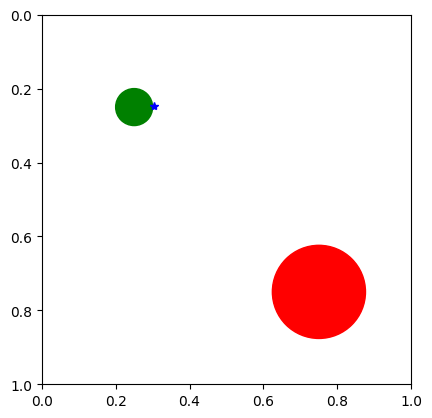

In [11]:
frames = []

sim = SimulationEnvironment0(num_simulations=1,
                                num_blackholes=num_blackholes, 
                                force_constant=0.002, 
                                velocity_scale=0.01,
                                goal_threshold=0.05,
                                max_steps=250,
                                device='cuda')

sim.states[0,0] = torch.tensor([0.9,0.6])
sim.states[0,1] = torch.tensor([0.25,0.25])
sim.states[0,2] = torch.tensor([0.75,0.75])

states = sim.get_state()


for i in range(200):
    
    # plot

    #time.sleep(0.25)

    fig, ax = plt.subplots()
    plt.plot(states[0,0,0].cpu(),states[0,0,1].cpu(),'*b')
    goal = plt.Circle((states[0,1,0].cpu(),states[0,1,1].cpu()),sim.goal_threshold, color='g')
    ax.add_patch(goal)
    black_hole =plt.Circle((states[0,2,0].cpu(),states[0,2,1].cpu()),sim.crash_threshold, color='r')
    ax.add_patch(black_hole)
    ax.set_aspect('equal')
    plt.xlim([0,1])
    plt.ylim([1,0])
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(img)
    clear_output()
    plt.show()
    
    # flatten the state
    states = states.reshape(states.shape[0],-1).cuda()

    # compute action distribution according to the current policy
    actions, _, _ = actor(states)
    dist = compute_dist(actions)

    # sample an action
    sampled_action = dist.sample()
    sampled_action_decoded, log_prob = decode_action(dist, sampled_action)

    # simulation step
    rewards, states, terminals = sim.step(sampled_action_decoded)

    if torch.any(terminals):
        break

In [12]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(frames, fps=20)
clip.write_gif('resources/final.gif', fps=20)

MoviePy - Building file resources/final.gif with imageio.


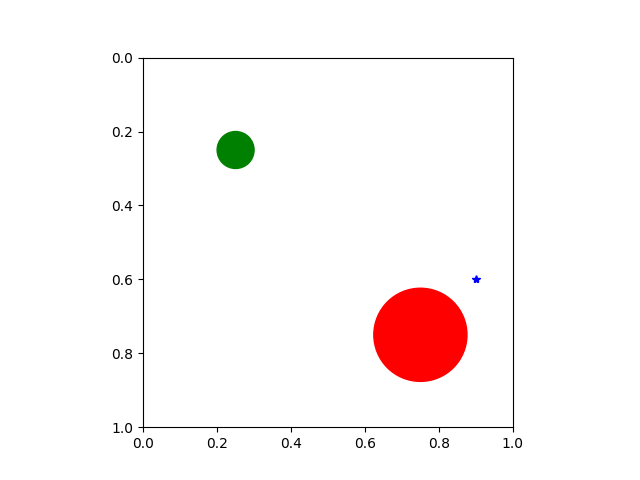

In [13]:
from IPython.display import display, Image
Image('resources/final.gif')